## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

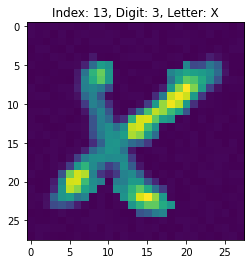

In [29]:
idx = 13
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [6]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [7]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [8]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [9]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [10]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [47]:
# 초반 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)
history = model.fit(
  datagen.flow(x_edit2, y_train, batch_size=32),
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//32,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
64/64 [==============================] - 2s 35ms/step - loss: 3.7487 - accuracy: 0.3091
Epoch 2/200
64/64 [==============================] - 2s 35ms/step - loss: 2.5742 - accuracy: 0.3721
Epoch 3/200
64/64 [==============================] - 2s 35ms/step - loss: 2.3572 - accuracy: 0.4434
Epoch 4/200
64/64 [==============================] - 2s 35ms/step - loss: 2.2602 - accuracy: 0.4595
Epoch 5/200
64/64 [==============================] - 2s 35ms/step - loss: 2.1791 - accuracy: 0.4902
Epoch 6/200
64/64 [==============================] - 2s 35ms/step - loss: 2.0462 - accuracy: 0.5068
Epoch 7/200
64/64 [==============================] - 2s 35ms/step - loss: 2.0188 - accuracy: 0.5181
Epoch 8/200
64/64 [==============================] - 2s 35ms/step - loss: 1.9291 - accuracy: 0.5264
Epoch 9/200
64/64 [==============================] - 2s 35ms/step - loss: 1.8786 - accuracy: 0.5493
Epoch 10/200
64/64 [==============================] - 2s 35ms/step - loss: 1.8495 - accuracy: 0.5542

64/64 [==============================] - 2s 34ms/step - loss: 0.6670 - accuracy: 0.8892
Epoch 80/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6363 - accuracy: 0.8936
Epoch 81/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6581 - accuracy: 0.8945
Epoch 82/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6423 - accuracy: 0.8984
Epoch 83/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6407 - accuracy: 0.8979
Epoch 84/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6349 - accuracy: 0.9028
Epoch 85/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6489 - accuracy: 0.8882
Epoch 86/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6418 - accuracy: 0.8984
Epoch 87/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6402 - accuracy: 0.8945
Epoch 88/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6221 - accuracy: 0.8979
Epo

64/64 [==============================] - 2s 34ms/step - loss: 0.6015 - accuracy: 0.9043
Epoch 160/200
64/64 [==============================] - 2s 33ms/step - loss: 0.5864 - accuracy: 0.9185
Epoch 161/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6011 - accuracy: 0.9058
Epoch 162/200
64/64 [==============================] - 2s 34ms/step - loss: 0.5752 - accuracy: 0.9243
Epoch 163/200
64/64 [==============================] - 2s 33ms/step - loss: 0.5948 - accuracy: 0.9146
Epoch 164/200
64/64 [==============================] - 2s 34ms/step - loss: 0.5746 - accuracy: 0.9263
Epoch 165/200
64/64 [==============================] - 2s 34ms/step - loss: 0.5934 - accuracy: 0.9233
Epoch 166/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6147 - accuracy: 0.9019
Epoch 167/200
64/64 [==============================] - 2s 34ms/step - loss: 0.6038 - accuracy: 0.9023
Epoch 168/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6212 - accuracy: 0

In [48]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #앞에거에 이어서 학습
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train2, y_train, batch_size=32),
  epochs=epochs, 
  steps_per_epoch = x_train2.shape[0]//32,
  callbacks=[annealer], 
  verbose = 1)

Epoch 1/200
64/64 [==============================] - 2s 35ms/step - loss: 1.9416 - accuracy: 0.5186
Epoch 2/200
64/64 [==============================] - 2s 34ms/step - loss: 1.3361 - accuracy: 0.6782
Epoch 3/200
64/64 [==============================] - 2s 34ms/step - loss: 0.9963 - accuracy: 0.7783
Epoch 4/200
64/64 [==============================] - 2s 33ms/step - loss: 0.9233 - accuracy: 0.7979
Epoch 5/200
64/64 [==============================] - 2s 33ms/step - loss: 0.8504 - accuracy: 0.8027
Epoch 6/200
64/64 [==============================] - 2s 34ms/step - loss: 0.7535 - accuracy: 0.8369
Epoch 7/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6798 - accuracy: 0.8550
Epoch 8/200
64/64 [==============================] - 2s 33ms/step - loss: 0.6171 - accuracy: 0.8677
Epoch 9/200
64/64 [==============================] - 2s 35ms/step - loss: 0.5597 - accuracy: 0.8916
Epoch 10/200
64/64 [==============================] - 2s 34ms/step - loss: 0.5487 - accuracy: 0.8892

64/64 [==============================] - 2s 34ms/step - loss: 0.0969 - accuracy: 0.9956
Epoch 80/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0936 - accuracy: 0.9927
Epoch 81/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0920 - accuracy: 0.9961
Epoch 82/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0961 - accuracy: 0.9932
Epoch 83/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0920 - accuracy: 0.9941
Epoch 84/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0942 - accuracy: 0.9937
Epoch 85/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0868 - accuracy: 0.9971
Epoch 86/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0899 - accuracy: 0.9961
Epoch 87/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0890 - accuracy: 0.9951
Epoch 88/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0931 - accuracy: 0.9937
Epo

64/64 [==============================] - 2s 34ms/step - loss: 0.0846 - accuracy: 0.9966
Epoch 160/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0874 - accuracy: 0.9951
Epoch 161/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0820 - accuracy: 0.9971
Epoch 162/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0821 - accuracy: 0.9971
Epoch 163/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0783 - accuracy: 0.9985
Epoch 164/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0796 - accuracy: 0.9980
Epoch 165/200
64/64 [==============================] - 2s 35ms/step - loss: 0.0826 - accuracy: 0.9966
Epoch 166/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0874 - accuracy: 0.9951
Epoch 167/200
64/64 [==============================] - 2s 34ms/step - loss: 0.0867 - accuracy: 0.9956
Epoch 168/200
64/64 [==============================] - 2s 33ms/step - loss: 0.0841 - accuracy: 0

## Predict

In [49]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [50]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [51]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [52]:
submission.to_csv('batchsize 둘다32.csv', index=False)

---

In [81]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [82]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [83]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,2
3,2052,8
4,2053,8
5,2054,8
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [84]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('두번 이어서 훈련_이진화otest.csv', index=False)